In [1]:
FRAME_SIZE = 20000
HOP_RATIO = 0.1
N_FFT = 1024
VIGILANCE = 1000

In [2]:
from modules.AudioProcessor import AudioProcessor

audio_files = [
    './dataset/trimmed_crowd_talking.mp3',
    './dataset/trimmed_motor_riding.mp3',
    './dataset/trimmed_water_flowing.mp3'
]
ap = AudioProcessor(
    audio_files, 
    frame_size_ms=FRAME_SIZE, 
    hop_length_ratio=HOP_RATIO
    )
print(ap.frames.shape)
print(ap.class_ids.shape)
print(ap.timestamps.shape)

torch.Size([153, 960000])
(153,)
(153,)


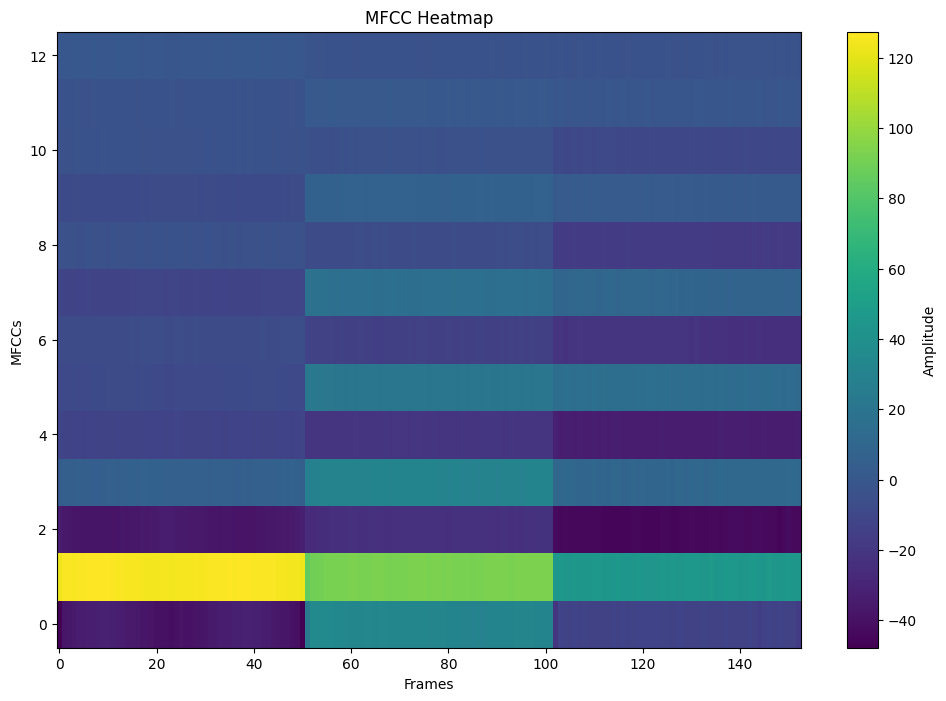

torch.Size([153, 13])

In [3]:
from modules.FeatureExtractor import FeatureExtractor

fe = FeatureExtractor(n_fft=N_FFT)
fe.extract_mfcc(ap.frames, normalize=False)
fe.plot_mfccs()
fe.mfcc_features.shape

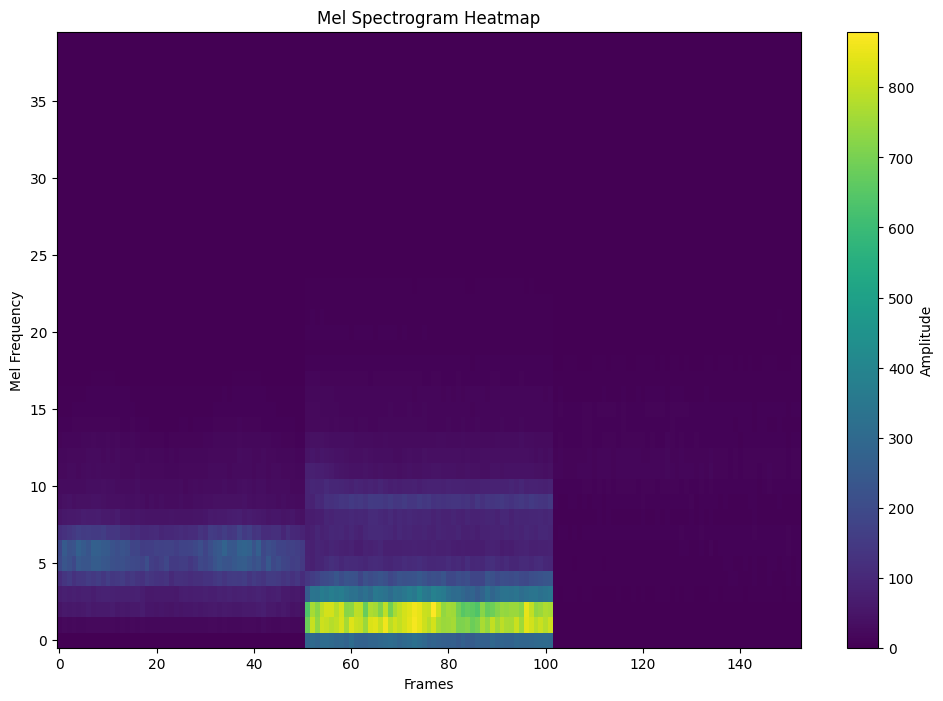

torch.Size([153, 40])

In [4]:
fe.extract_melspectrogram(ap.frames, normalize=False)
fe.plot_melspectrogram()
fe.melspectrogram_features.shape

In [5]:
important_mfcc_features = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]
important_mfsc_features = [i for i in range(14)] + [i for i in range(16, 35)]

from modules.DatasetHandler import DatasetHandler

dh = DatasetHandler(
    ap.class_ids,
    ap.timestamps, 
    fe.mfcc_features, 
    fe.melspectrogram_features, 
    len(important_mfcc_features) + len(important_mfsc_features)
)
dh.generate_csv()
dh.save_selected_features(important_mfcc_features, important_mfsc_features)

time_series_tensor = dh.generate_time_series(FRAME_SIZE, HOP_RATIO)
time_series_tensor.shape

torch.Size([5, 60, 44])

In [6]:
from modules.ART2Clusterer import ART2Clusterer

for i in range(len(time_series_tensor)):
    clusterer = ART2Clusterer(
        VIGILANCE, 
        time_series_tensor.shape[2],
        n_clusters=3000,
        max_samples_per_cluster=time_series_tensor.shape[1]+1
    )
    print(f"Clustering samples for time series {i}")
    for j, sample in enumerate(time_series_tensor[i]):
        clusterer.fit_clusters(sample, j)
    print("Clustering completed")
    confusion_matrix = clusterer.calc_confusion_matrix(f'./output/ground_truth_{i}.csv')
    print(f"Confusion matrix:\n{confusion_matrix}")
    clusterer.plot_truth_vs_time(f'./output/ground_truth_{i}.csv')
    accuracy = clusterer.calc_accuracy(confusion_matrix)
    print(f"Accuracy: {accuracy*100}%\n")

Clustering samples for time series 0
Clustering completed


ValueError: too many values to unpack (expected 2)